# Title
*Concrete Strength Prediction_20200303_01_VinuPillai*

## Purpose
To predict the concrete strength using the data available in file concrete.csv. Apply feature engineering and model tuning to obtain 85% to 95% accuracy.

## Methodology
Below is a brief description of the methodology taken to solve the problem

### Processing steps
**Exploratory data quality report reflecting the following**
* Univariate analysis – data types and description of the independent attributes which should include (name, meaning, range of values observed, central values (mean and median), standard deviation and quartiles, analysis of the body of distributions / tails, missing values, outliers
* Bi-variate analysis between the predictor variables and between the predictor variables and target column. Comment on your findings in terms of their relationship and degree of relation if any. Visualize the analysis using boxplots and pair plots, histograms or density curves. Select the most appropriate attributes
* Strategies to address the different data challenges such as data pollution, outliers and missing values

**Feature Engineering techniques**
* Identify opportunities (if any) to create a composite feature, drop a feature
* Decide on complexity of the model, should it be simple linear model in terms of parameters or would a quadratic or higher degree help
* Explore for Gaussians and comment on the distribution. Use pairplot or distplot to visualize the same

**Creating the model and tuning it**
* Algorithms that you think will be suitable for this project.
* Techniques employed to squeeze that extra performance out of the model without making it over fit or under fit.
* Optional - Model performance range at 95% confidence level

### Input Variables
* Cement (cement): quantitative. kg in a m3 mixture
* Blast Furnace Slag (slag) -- quantitative -- kg in a m3 mixture
* Fly Ash (ash) -- quantitative -- kg in a m3 mixture 
* Water (water) -- quantitative -- kg in a m3 mixture 
* Superplasticizer (superplastic) -- quantitative -- kg in a m3 mixture
* Coarse Aggregate (coarseagg) -- quantitative -- kg in a m3 mixture
* Fine Aggregate (fineagg) -- quantitative -- kg in a m3 mixture
* Age (age) -- quantitative -- Day (1~365)

### Predictor Variable
* Concrete compressive strength(strength) -- quantitative -- MPa

# Setup

## Library import
We import all the required Python libraries

In [1]:
# Data manipulation modules
import pandas as pd
import numpy as np

# Scikit learn related modules
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import KFold

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, HuberRegressor, Lasso, Ridge
from sklearn.pipeline import Pipeline

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor

import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')


# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations Seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

## Generic Functions
Define all the generic functions used in the analysis

In [2]:
def plot_heat_map(data):
    #get correlations of each features in dataset
    corrmat = data.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(12,12))
    #plot heat map
    g=sns.heatmap(data[top_corr_features].corr(),annot=True, cmap="RdYlGn")
    plt.show()

def print_model_performance(model, X_test_actuals, y_test_actuals):
    print('Accuracy = {:0.4f}%.'.format(model.score(X_test_actuals, y_test_actuals) * 100))

def evaluate_model(X, y, model):
    cv = KFold(n_splits=10, random_state=1)
    scores = cross_val_score(model, X, y, scoring=make_scorer(r2_score), cv=cv, n_jobs=-1)
    return scores

def get_models():
    models, names, results = list(), list(), list()
    # Linear
    models.append(Pipeline(steps=[('model', LinearRegression())]))
    names.append('Linear')
    # Lasso
    models.append(Pipeline(steps=[('model', Lasso(alpha=0.01))]))
    names.append('Lasso')
    # Ridge
    models.append(Pipeline(steps=[('model', Ridge(alpha=0.01))]))
    names.append('Ridge')
    # Huber
    models.append(Pipeline(steps=[('model', HuberRegressor(alpha=0.01))]))
    names.append('Huber')
    # Huber + Normalization
    models.append(Pipeline(steps=[('t1', MinMaxScaler()), ('model', HuberRegressor())]))
    names.append('Huber with Min-Max')
    # Lasso + Normalization
    models.append(Pipeline(steps=[('t1', MinMaxScaler()), ('model', Lasso())]))
    names.append('Lasso with Min-Max')
    # Ridge + Normalization
    models.append(Pipeline(steps=[('t1', MinMaxScaler()), ('model', Ridge())]))
    names.append('Ridge with Min-Max')
    # Linear + Normalization
    models.append(Pipeline(steps=[('t1', MinMaxScaler()), ('model', LinearRegression())]))
    names.append('Linear with Min-Max')
    # Linear + Power
    models.append(Pipeline(steps=[('t1', PowerTransformer()), ('model', LinearRegression())]))
    names.append('Linear with Power')
    # Linear + Norm + Power
    models.append(Pipeline(steps=[('t1', MinMaxScaler()), ('t2', PowerTransformer()), ('model', LinearRegression())]))
    names.append('Linear with Min-Max + Power')
    # Linear + Standardization + Power
    models.append(Pipeline(steps=[('t1', MinMaxScaler()), ('t2', RobustScaler()), ('t3', PowerTransformer()), ('model', LinearRegression())]))
    names.append('Linear with Min-Max + Robust + Power')
    # Linear + Robust + Power
    models.append(Pipeline(steps=[('t1', RobustScaler()), ('t2', PowerTransformer()), ('model', LinearRegression())]))
    names.append('Linear with Robust + Power')
    return names, models

def evaluate_models(data_X, data_y, confidence=0.997):
    mean_results, std_results = list(), list()
    names, models = get_models()
    for i in range(len(models)):
        scores = evaluate_model(data_X, data_y, models[i])
        mean_results.append(np.mean(scores))
        std_results.append(np.std(scores))
        value = str('%.1f%%' % (max(0.0, np.percentile(scores, ((1.0 - confidence)/2.0) * 100)) * 100)) + ' - ' + str('%.1f%%' % (min(1.0, np.percentile(scores, (confidence + ((1.0 - confidence)/2.0)) * 100)) * 100))
    return pd.DataFrame({'Model': names, 'Mean' : mean_results, 'Std' : std_results, 'Confidence' + ' [ '+ str('%.1f%%' % (confidence * 100)) + ' ]' : value}).sort_values(by='Mean', ascending=False)

def score_models(train_X, train_y, test_X, test_y):
    results = list()
    names, models = get_models()
    for i in range(len(models)):
        models[i].fit(train_X, train_y)
        results.append(models[i].score(test_X, test_y))
    return pd.DataFrame({'Model': names, 'Score' : results}).sort_values(by='Score', ascending=False)

def evaluate_poly_features(data_X, data_y, degree):
    poly = PolynomialFeatures(degree = degree, interaction_only=True)
    X_poly = poly.fit_transform(data_X)
    d = evaluate_models(X_poly, concreteDf_y)
    d['degree'] = degree
    return d
        
def evaluate_poly_features_degrees(data_X, data_y, degrees):
    results = pd.DataFrame()
    for degree in degrees:
        results = pd.concat([results, evaluate_poly_features(data_X, data_y, degree)])
    return results

# Data import
All the required data for the analysis is imported here. Data is available in **'concrete.csv'**. The file contains samples of cement, ash, water, superplastic, aggregates etc which are required for making concrete.

In [3]:
concreteDf = pd.read_csv('concrete.csv')
concreteDf.head(10)

cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0   28   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7   28   
5   255.0    0.0    0.0  192.0           0.0      889.8    945.0   90   
6   166.8  250.2    0.0  203.5           0.0      975.6    692.6    7   
7   251.4    0.0  118.3  188.5           6.4     1028.4    757.7   56   
8   296.0    0.0    0.0  192.0           0.0     1085.0    765.0   28   
9   155.0  184.0  143.0  194.0           9.0      880.0    699.0   28   

   strength  
0     29.89  
1     23.51  
2     29.22  
3     45.85  
4     18.29  
5     21.86  
6     15.75  
7     36.64  
8     21.65  
9     28.99

## Overview of variables
* **Coarse aggregate** is one of the essential components of concrete and occupies the largest volume in the mix. That is why it greatly affects the concrete mix design. Its properties such as strength, maximum size, shape, and water absorption influence water demand, the quantity of cement and fine aggregate in concrete mixture
* **Aggregates** are the stuff that the cement paste coats and binds together. When the aggregate particles of the granular material are so fine that they pass through a 4.75mm sieve, it is called **fine aggregate**
* **Water** is an essential component when making concrete. The moisture that water provides also gives concrete its strength during the curing process. **While water is one of the most important ingredients in concrete, it can also be the most destructive in excessive amounts.**
* **Ash** has reduced permeability to **water** and aggressive chemicals. Properly cured concrete made with ash creates a denser product because the size of the pores are reduced. This **increases strength and reduces permeability**.
* **Superplastic** are additives used in making high strength concrete

This indicates that all the variables are important in giving concrete its strength.

In [4]:
concreteDf.shape

(1030, 9)

# Data Analysis

Check if the data has any null values

In [5]:
concreteDf.isna().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

Get an overview of the different variables and the type of data involved

In [6]:
concreteDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


Since the variables are all numeric, we can check the 5 point summary along with the mean and standard deviation involved in the data set

In [7]:
concreteDf.describe().T

count        mean         std     min      25%      50%  \
cement        1030.0  281.167864  104.506364  102.00  192.375  272.900   
slag          1030.0   73.895825   86.279342    0.00    0.000   22.000   
ash           1030.0   54.188350   63.997004    0.00    0.000    0.000   
water         1030.0  181.567282   21.354219  121.80  164.900  185.000   
superplastic  1030.0    6.204660    5.973841    0.00    0.000    6.400   
coarseagg     1030.0  972.918932   77.753954  801.00  932.000  968.000   
fineagg       1030.0  773.580485   80.175980  594.00  730.950  779.500   
age           1030.0   45.662136   63.169912    1.00    7.000   28.000   
strength      1030.0   35.817961   16.705742    2.33   23.710   34.445   

                   75%     max  
cement         350.000   540.0  
slag           142.950   359.4  
ash            118.300   200.1  
water          192.000   247.0  
superplastic    10.200    32.2  
coarseagg     1029.400  1145.0  
fineagg        824.000   992.6  
age             56.000   365.0  
strength        46.135    82.6

* This shows that there are no negative values. 
* 3 variables have a lot of 0s. Ash has significantly large amount of 0s that may indicate a lot of skewness towards the 0 value and potential outliers
* Other attributes have proper values that are comparatively cleaner

## Univariate Plots

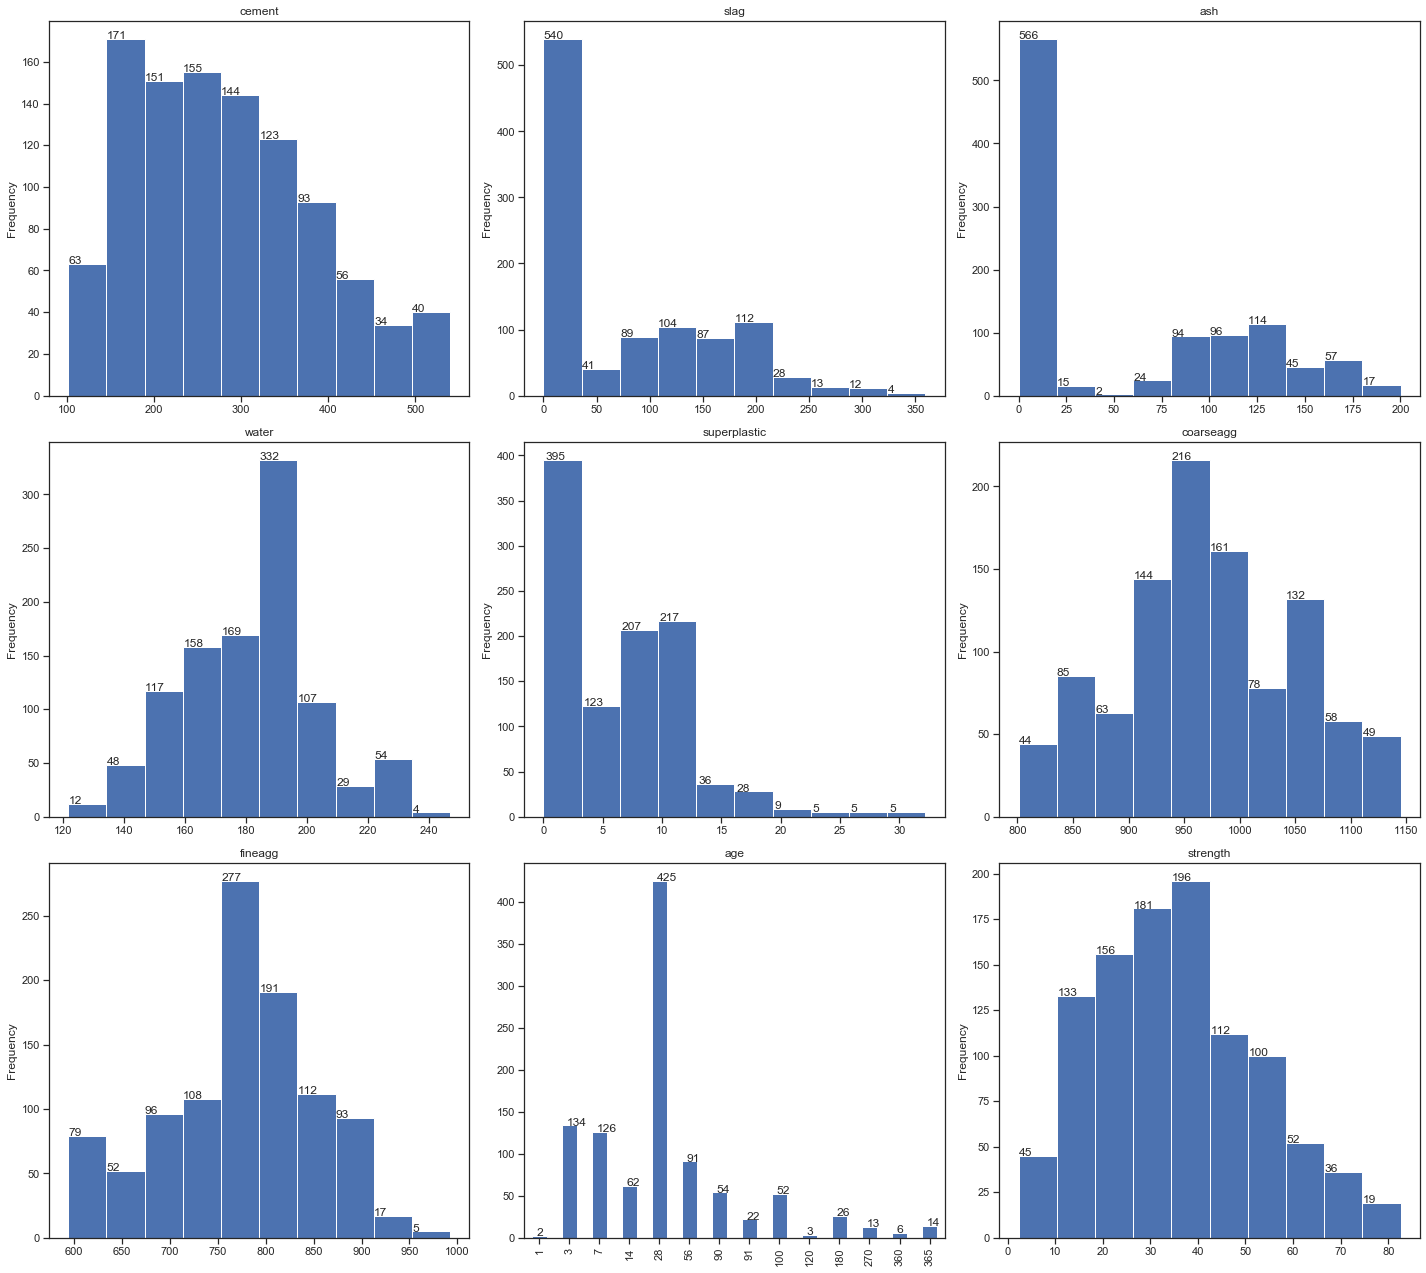

In [8]:
plot_types = {
    'cement': 'hist',
    'slag': 'hist',
    'ash': 'hist',
    'water': 'hist',
    'superplastic': 'hist',
    'coarseagg': 'hist',
    'fineagg': 'hist',
    'age': 'bar',
    'strength': 'hist'
}
fig = plt.figure(figsize=(20, 35))
for feature, num in zip(concreteDf.columns, range(1, len(concreteDf.columns) + 1)):
    ax = fig.add_subplot(6, 3, num)
    ax.set_title(feature)
    if plot_types[feature] == 'hist':
        concreteDf[feature].sort_index().plot(kind=plot_types[feature])
    elif plot_types[feature] == 'bar':
        concreteDf[feature].value_counts().sort_index().plot(kind=plot_types[feature])
    elif plot_types[feature] == 'line':
        concreteDf[feature].value_counts().sort_index().plot(kind=plot_types[feature])
    elif plot_types[feature] == 'dist':
        sns.distplot(concreteDf[feature])
    for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + 0.15, p.get_height()))
plt.tight_layout()
plt.show()

## Pair Plot

A pair plot of all the variables will indicate th distribution of each variables and how they influence the target variable

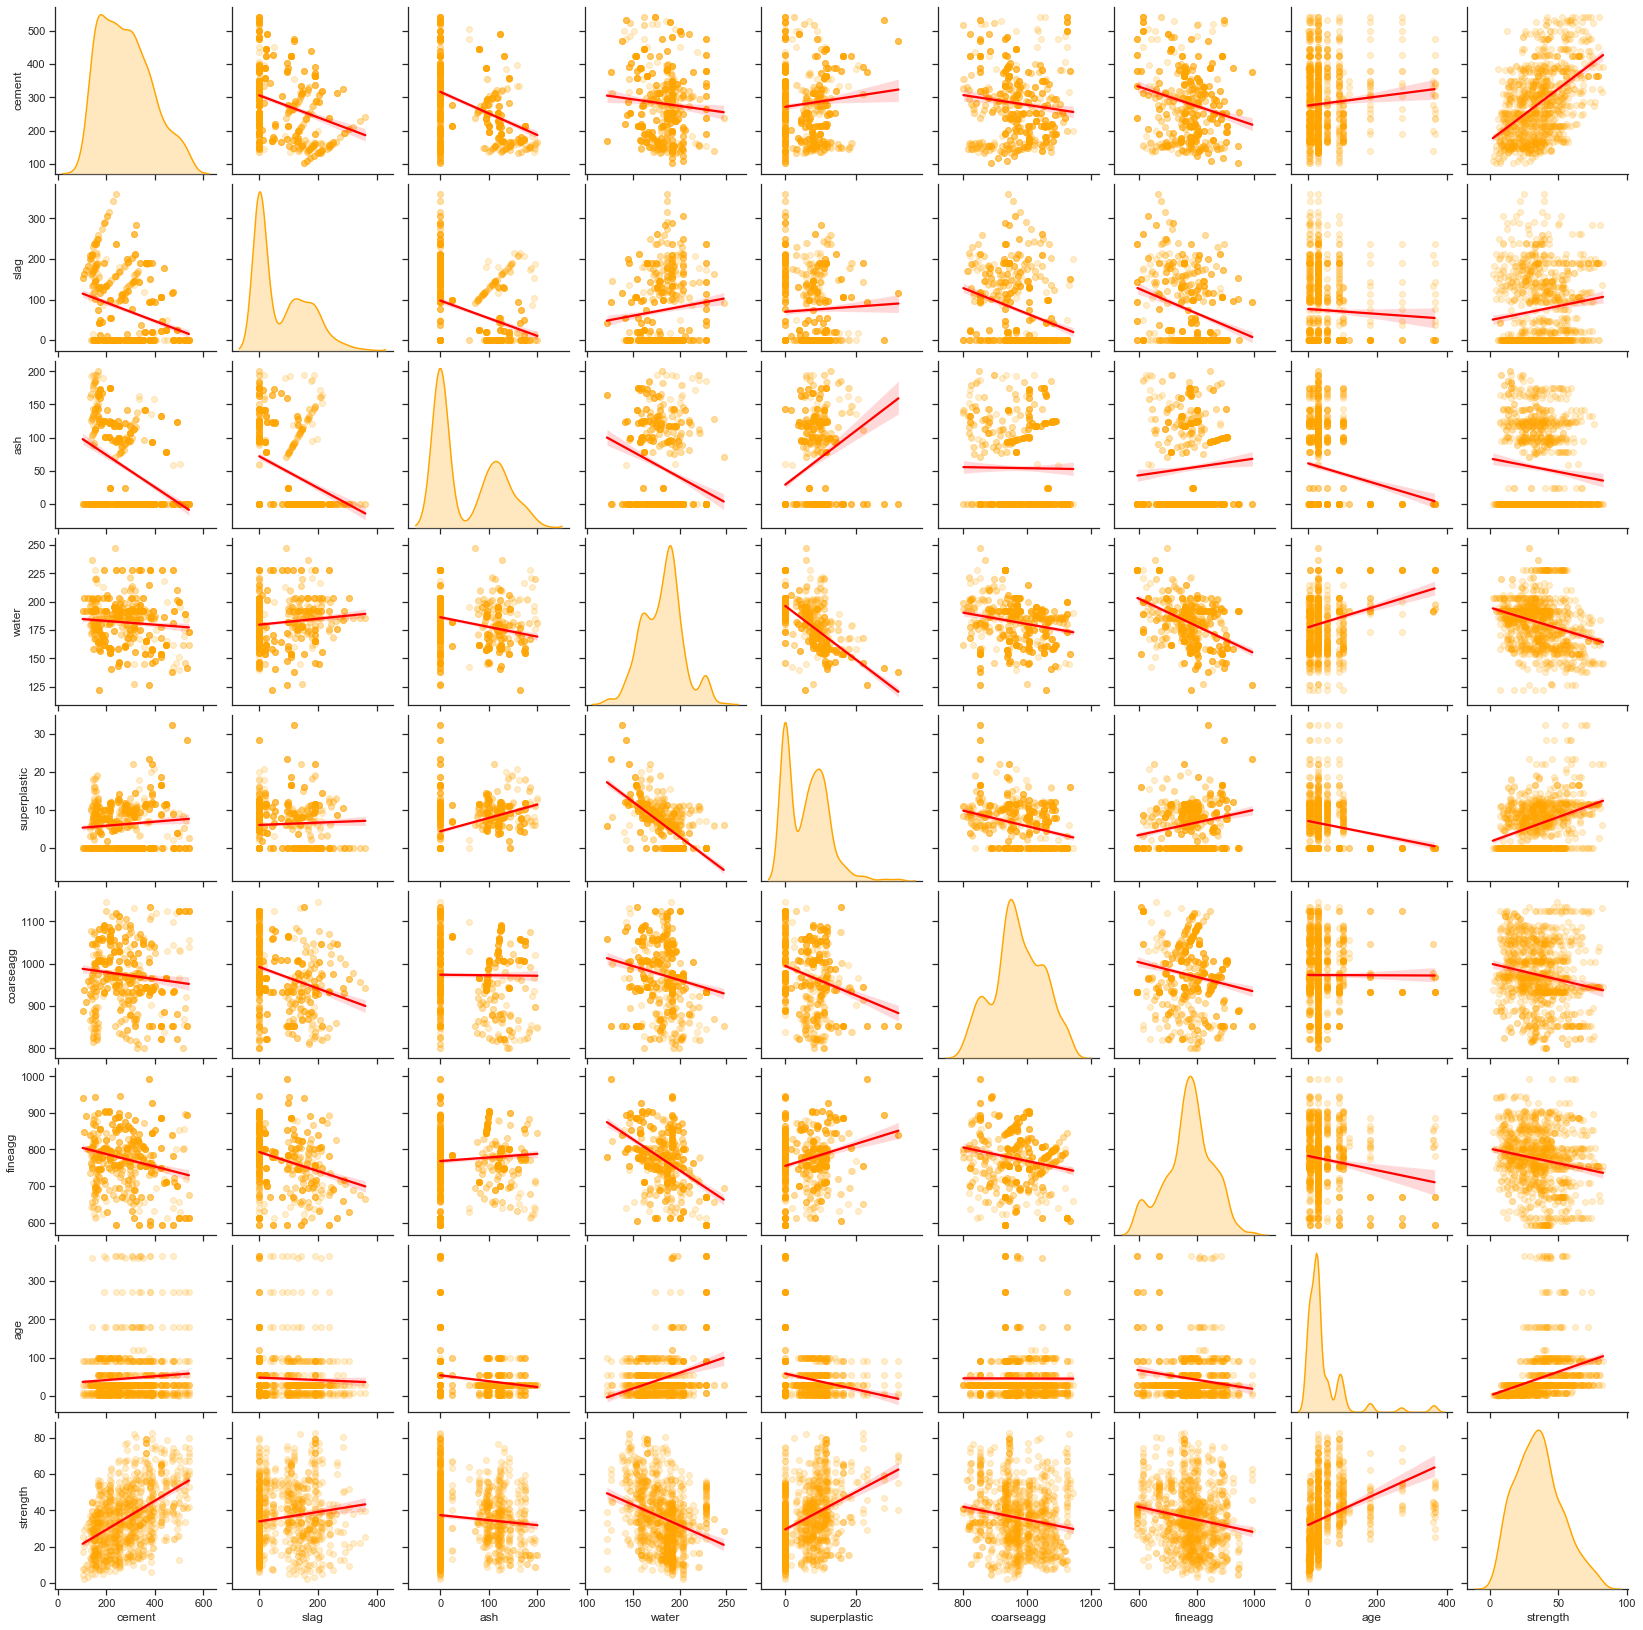

In [9]:
sns.pairplot(concreteDf, diag_kind='kde', kind='reg', diag_kws={'color':'orange'},
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.2, 'color':'orange'}})

**Analysis**
* Cement is fairly uniformly distributed. It has a positive correlation with the target variable. It has very low correlation with water super plastic and aggregates
* Slag is a key ingredient for making concrete strong. It has slight correlation with the target variable. There is a mix up of gaussians. A lot of values are 0. Since it is a key ingredient, there is a possibility that these 0s need to be imputed
* Ash is a weak predictor from the dataset. However it is also a key ingredient and hence cannot be ignored. A lot of values are 0. There is a possibility that these 0s need to be imputed
* Water is a strong predictor. More amount of water, less is the strength. Distribution is not fairly normal. It has a few outliers because of the multiple spikes. Potentially 3 groups exist within the data set
* Superplastic is also a key ingredient for strength and is also showing as a very strong predictor. However a lot of values exist as 0 which might need treatment. 
* Coarseagg and Fineagg are also useful predictors of strength. Their distribution is also not completely normal with a few spikes and potential outliers.
* Age is fairly weak predictor except for values between 50 and 150 where it shows the maximum strength. Other age ranges don't show variation in strength. However this cannot be ignored as age is a vital component for strength.

# Data processing
All the core processing of the notebook is defined in each of the subsections

In [10]:
# Let us first take a copy of the data before we start the first treatment to baseline performance
concreteDf_baseline = concreteDf.copy()

## Normalization
* First let impute the the missing 0s with the mean of their respective variables to address the variation due to 0s. This might make the distribution  more thin
* Let us also combine the columns together and form aggregated columns and reduce the dimensions for better analysis.
    - 'coarseagg' and 'fineagg' will be merged and a new attribute call 'agg' will be created
    - 'slag' and 'superplastic are having a positive trend on strength and hence will be combined together to form a new variable 'slag_plastic'
    - 'water' and 'ash' have a negative trend on strength and hence we can combine them together to form 'water_ash' as a new variable

In [11]:
transformed_values_baseline = ColumnTransformer(transformers=[('imputer', SimpleImputer(missing_values=0, strategy='mean'), ['slag', 'ash', 'superplastic'])]).fit_transform(concreteDf_baseline)
concreteDf_baseline['slag'] = pd.Series(transformed_values_baseline[:,0])
concreteDf_baseline['ash'] = pd.Series(transformed_values_baseline[:,1])
concreteDf_baseline['superplastic'] = pd.Series(transformed_values_baseline[:,2])

concreteDf_baseline['agg'] = np.sqrt(np.square(concreteDf_baseline['coarseagg']) + np.square(concreteDf_baseline['fineagg']))
concreteDf_baseline['slag_plastic'] = concreteDf_baseline['slag'] + concreteDf_baseline['superplastic']
concreteDf_baseline['water_ash'] = concreteDf_baseline['water'] + concreteDf_baseline['ash']

logTransformer_baseline = FunctionTransformer(np.log1p)
powerTransformer_baseline = PowerTransformer()
concreteDf_baseline['age'] = logTransformer_baseline.fit_transform(concreteDf_baseline['age'])
concreteDf_baseline['slag_plastic'] = powerTransformer_baseline.fit_transform(concreteDf_baseline[['slag_plastic']])
concreteDf_baseline['water_ash'] = powerTransformer_baseline.fit_transform(concreteDf_baseline[['water_ash']])
concreteDf_baseline['agg'] = powerTransformer_baseline.fit_transform(concreteDf_baseline[['agg']])

* Once the new attributes are created, we also notice that the values have a variation that might need to be reduced in order to process it further.
    - 'Age' can be reduced using the log transformer
    - New variables 'slag_plastic', 'water_ash' and 'agg' can be scaled using the power transformer to make the distribution more gaussian like for analysis

## Plot for baseline
Remove the existing variables after the aggregated variables are created for plot and analysis

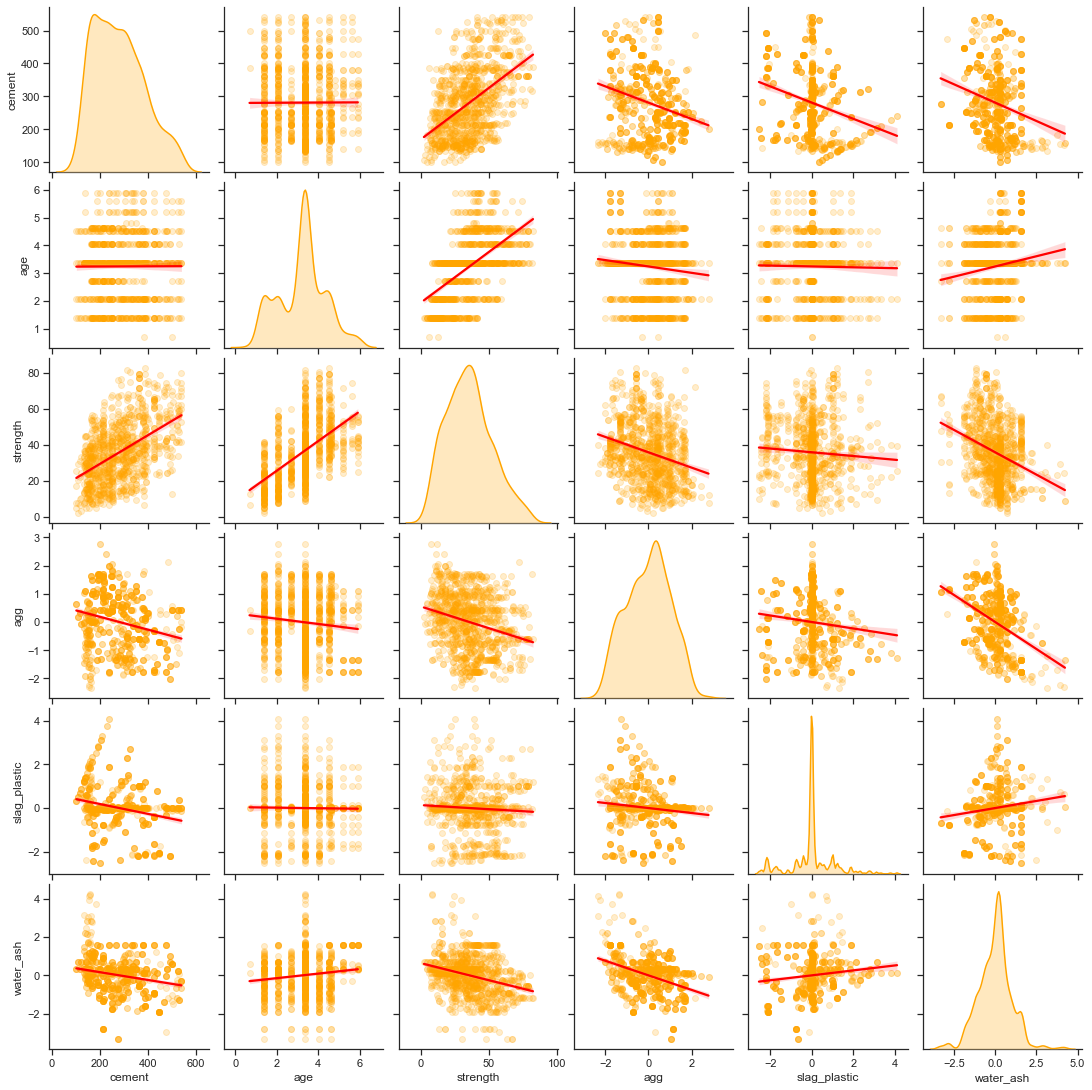

In [12]:
concreteDf_baseline.drop(columns=['water', 'ash', 'coarseagg', 'fineagg', 'slag', 'superplastic'], inplace=True)
sns.pairplot(concreteDf_baseline, diag_kind='kde', kind='reg', diag_kws={'color':'orange'},
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.2, 'color':'orange'}})

Many of the variables have become uniform except for 'slag_plastic' and 'water_ash'. This will need to be retreated after the baseline performance is obtained. 

## $R^2$ & Adjusted $R^2$

Let's view the summary report of the target variable in terms of OLS in terms of all the other independent variables

In [13]:
ols_baseline = smf.ols(formula= 'strength ~ cement+age+agg+slag_plastic+water_ash', data = concreteDf_baseline).fit()
print(ols_baseline.summary())

                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     432.5
Date:                Mon, 09 Mar 2020   Prob (F-statistic):          1.81e-249
Time:                        22:04:00   Log-Likelihood:                -3776.6
No. Observations:                1030   AIC:                             7565.
Df Residuals:                    1024   BIC:                             7595.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -8.5095      1.287     -6.610   

Adjusted $R^2$ is coming to around **0.67**

## Baseline 1

In [14]:
concreteDf_baseline_X = concreteDf_baseline.loc[:, concreteDf_baseline.columns != 'strength']
concreteDf_baseline_y = concreteDf_baseline['strength']
evaluate_models(concreteDf_baseline_X, concreteDf_baseline_y)

Model      Mean       Std  \
1                                  Lasso  0.663828  0.059415   
2                                  Ridge  0.663806  0.059517   
0                                 Linear  0.663806  0.059518   
7                    Linear with Min-Max  0.663806  0.059518   
6                     Ridge with Min-Max  0.663417  0.057288   
4                     Huber with Min-Max  0.660596  0.062001   
3                                  Huber  0.660139  0.060577   
8                      Linear with Power  0.657799  0.056817   
9            Linear with Min-Max + Power  0.657359  0.057161   
11            Linear with Robust + Power  0.655299  0.057476   
10  Linear with Min-Max + Robust + Power  0.655299  0.057476   
5                     Lasso with Min-Max  0.388826  0.039127   

   Confidence [ 99.7% ]  
1         58.6% - 78.6%  
2         58.6% - 78.6%  
0         58.6% - 78.6%  
7         58.6% - 78.6%  
6         58.6% - 78.6%  
4         58.6% - 78.6%  
3         58.6% - 78.6%  
8         58.6% - 78.6%  
9         58.6% - 78.6%  
11        58.6% - 78.6%  
10        58.6% - 78.6%  
5         58.6% - 78.6%

* Out of all the models tried, the Lasso gives the highest score as the first cut with a mean score of **66.38%**. Scores are calculated from 10 folds from the dataset and aggregated.
* **Linear with Power transformation** has the **lowest standard deviation** in that range
* Both the above can be picked up as a first baseline

### Univariate Plots for Outlier detection

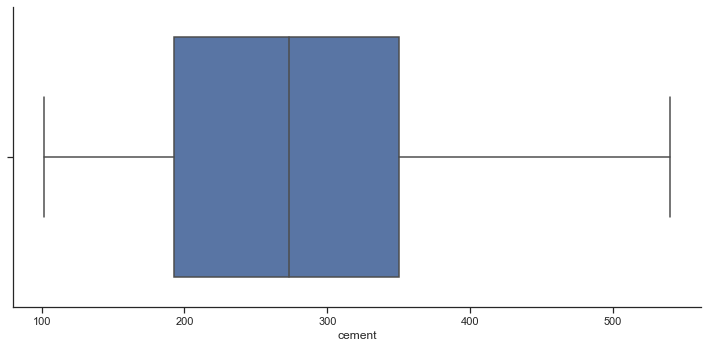

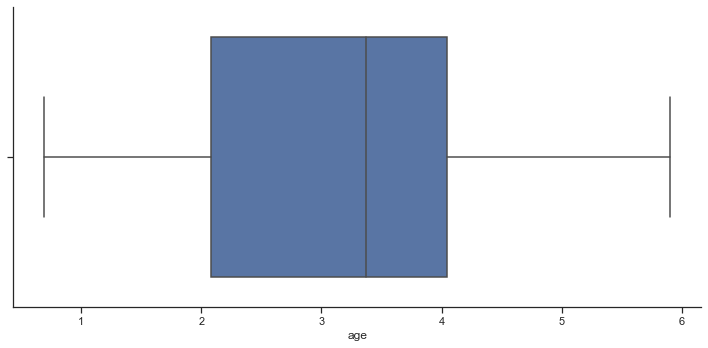

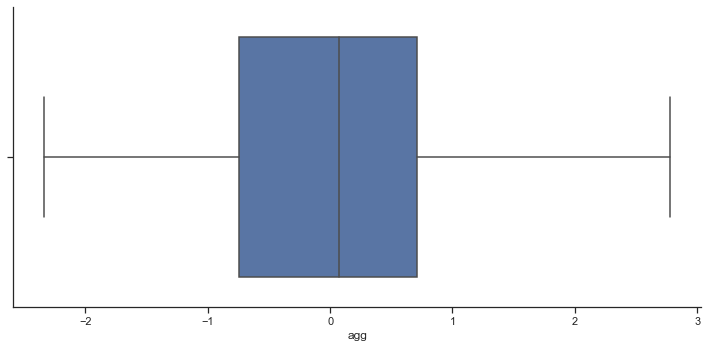

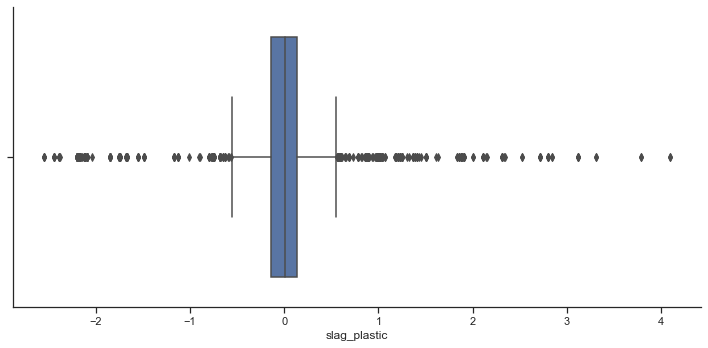

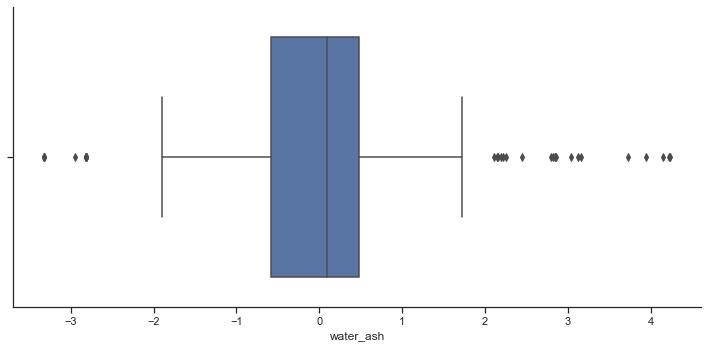

In [15]:
for feature in concreteDf_baseline_X.columns:
    sns.catplot(x=feature, kind='box', data=concreteDf_baseline_X, aspect=2)

The above plot shows a lot of outliers in 'slagplastic' and 'water_ash' variables. The transformation done via scaling has resulted in outliers due to 0 value imputation.

### Baseline 1 Model

In [16]:
X_baseline_train, X_baseline_test, y_baseline_train, y_baseline_test = train_test_split(
    concreteDf_baseline_X, concreteDf_baseline_y, test_size=0.3, random_state=1)
baseline_regr = LinearRegression()
baseline_regr.fit(X_baseline_train, y_baseline_train)
print_model_performance(baseline_regr, X_baseline_test, y_baseline_test)
y_baseline_pred = baseline_regr.predict(X_baseline_test)
y_baseline_score = baseline_regr.score(X_baseline_test, y_baseline_test)

Accuracy = 68.7816%.


After splitting the data and using a plain vanill 'LinearRegression' model, we got a score of **68.78%**. This is our first baseline

## Baseline 2

In [17]:
concreteDf_baseline_1 = concreteDf.copy()

Let us not do 0 value imputation as it resulted in a lot of outliers earlier in Baseline 1. We will continue to use all other parameters in aggregated manner

In [18]:
concreteDf_baseline_1['agg'] = np.sqrt(np.square(concreteDf_baseline_1['coarseagg']) + np.square(concreteDf_baseline_1['fineagg']))
concreteDf_baseline_1['slag_plastic'] = concreteDf_baseline_1['slag'] + concreteDf_baseline_1['superplastic']
concreteDf_baseline_1['water_ash'] = concreteDf_baseline_1['water'] + concreteDf_baseline_1['ash']

logTransformer_baseline_1 = FunctionTransformer(np.log1p)
powerTransformer_baseline_1 = PowerTransformer()
concreteDf_baseline_1['age'] = logTransformer_baseline.fit_transform(concreteDf_baseline_1['age'])
concreteDf_baseline_1['slag_plastic'] = powerTransformer_baseline.fit_transform(concreteDf_baseline_1[['slag_plastic']])
concreteDf_baseline_1['water_ash'] = powerTransformer_baseline.fit_transform(concreteDf_baseline_1[['water_ash']])
concreteDf_baseline_1['agg'] = powerTransformer_baseline.fit_transform(concreteDf_baseline_1[['agg']])

### Plotting for analysis

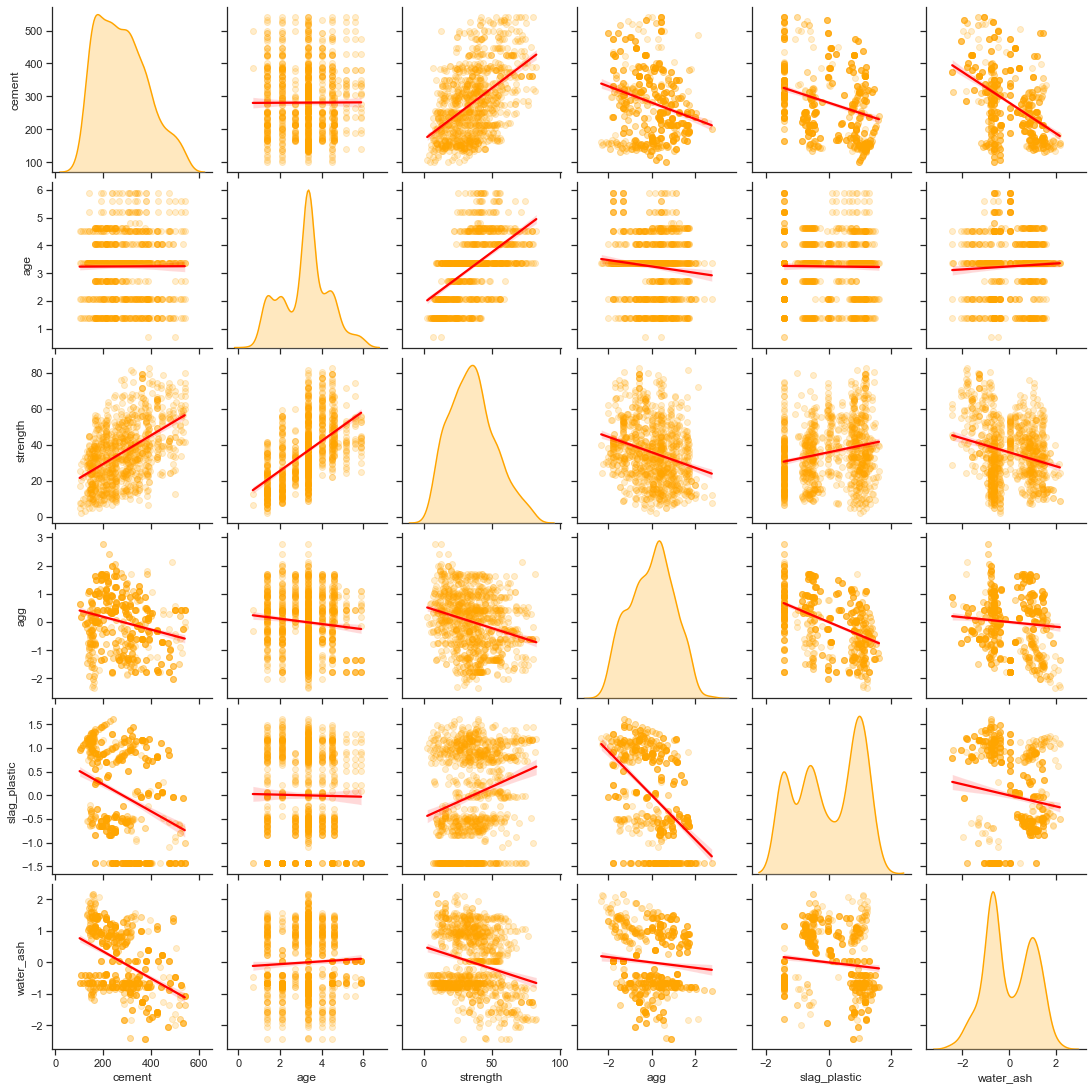

In [19]:
concreteDf_baseline_1.drop(columns=['water', 'ash', 'coarseagg', 'fineagg', 'slag', 'superplastic'], inplace=True)
sns.pairplot(concreteDf_baseline_1, diag_kind='kde', kind='reg', diag_kws={'color':'orange'},
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.2, 'color':'orange'}})

Data is more uniform as compared to earlier plots for all variables. Except there are a lot of mixup of gaussians in the dataset which need to be addressed. 'slag_plastic' and 'water_ash' continue to have outliers

### $R^2$ & Adjusted $R^2$

In [20]:
ols_baseline_1 = smf.ols(formula= 'strength ~ cement+age+agg+slag_plastic+water_ash', data = concreteDf_baseline_1).fit()
print(ols_baseline_1.summary())

                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     664.3
Date:                Mon, 09 Mar 2020   Prob (F-statistic):          2.28e-318
Time:                        22:04:16   Log-Likelihood:                -3616.8
No. Observations:                1030   AIC:                             7246.
Df Residuals:                    1024   BIC:                             7275.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -32.8424      1.353    -24.267   

Adjusted $R^2$ has improved from our earlier estimate to **0.763**. We will hence leave the 0 as is and investigate if the aggregated columns are necessary or leave the individual columns as is.

### Baseline 2 Model

In [21]:
concreteDf_baseline_1_X = concreteDf_baseline_1.loc[:, concreteDf_baseline_1.columns != 'strength']
concreteDf_baseline_1_y = concreteDf_baseline_1['strength']
evaluate_models(concreteDf_baseline_1_X, concreteDf_baseline_1_y)

Model      Mean       Std  \
1                                  Lasso  0.755945  0.031076   
2                                  Ridge  0.755943  0.031037   
0                                 Linear  0.755943  0.031037   
7                    Linear with Min-Max  0.755943  0.031037   
3                                  Huber  0.755335  0.031733   
4                     Huber with Min-Max  0.755168  0.031652   
6                     Ridge with Min-Max  0.753711  0.031707   
9            Linear with Min-Max + Power  0.752530  0.030068   
8                      Linear with Power  0.752220  0.030134   
11            Linear with Robust + Power  0.751180  0.030685   
10  Linear with Min-Max + Robust + Power  0.751180  0.030685   
5                     Lasso with Min-Max  0.466972  0.031913   

   Confidence [ 99.7% ]  
1         70.5% - 80.1%  
2         70.5% - 80.1%  
0         70.5% - 80.1%  
7         70.5% - 80.1%  
3         70.5% - 80.1%  
4         70.5% - 80.1%  
6         70.5% - 80.1%  
9         70.5% - 80.1%  
8         70.5% - 80.1%  
11        70.5% - 80.1%  
10        70.5% - 80.1%  
5         70.5% - 80.1%

Lasso seems to have the best scores and has significantly improved from Baseline 1

In [22]:
X_baseline_1_train, X_baseline_1_test, y_baseline_1_train, y_baseline_1_test = train_test_split(
    concreteDf_baseline_1_X, concreteDf_baseline_1_y, test_size=0.3, random_state=1)
baseline_1_regr = LinearRegression()
baseline_1_regr.fit(X_baseline_1_train, y_baseline_1_train)
print_model_performance(baseline_1_regr, X_baseline_1_test, y_baseline_1_test)
y_baseline_1_pred = baseline_1_regr.predict(X_baseline_1_test)
y_baseline_1_score = baseline_1_regr.score(X_baseline_1_test, y_baseline_1_test)

Accuracy = 77.3241%.


## First Cut Model
We will keep all the attributes as is instead of combining them and apply scaling and transformation to make the scales uniform

In [23]:
concreteDf_aggregated = concreteDf.copy()
logTransformer_aggregated = FunctionTransformer(np.log1p)
powerTransformer_aggregated = PowerTransformer()
concreteDf_aggregated['age'] = logTransformer_aggregated.fit_transform(concreteDf_aggregated['age'])
concreteDf_aggregated['slag'] = powerTransformer_aggregated.fit_transform(concreteDf_aggregated[['slag']])
concreteDf_aggregated['superplastic'] = powerTransformer_aggregated.fit_transform(concreteDf_aggregated[['superplastic']])
concreteDf_aggregated['water'] = powerTransformer_aggregated.fit_transform(concreteDf_aggregated[['water']])
concreteDf_aggregated['ash'] = powerTransformer_aggregated.fit_transform(concreteDf_aggregated[['ash']])
concreteDf_aggregated['coarseagg'] = powerTransformer_aggregated.fit_transform(concreteDf_aggregated[['coarseagg']])
concreteDf_aggregated['fineagg'] = powerTransformer_aggregated.fit_transform(concreteDf_aggregated[['fineagg']])

### Plotting for analysis

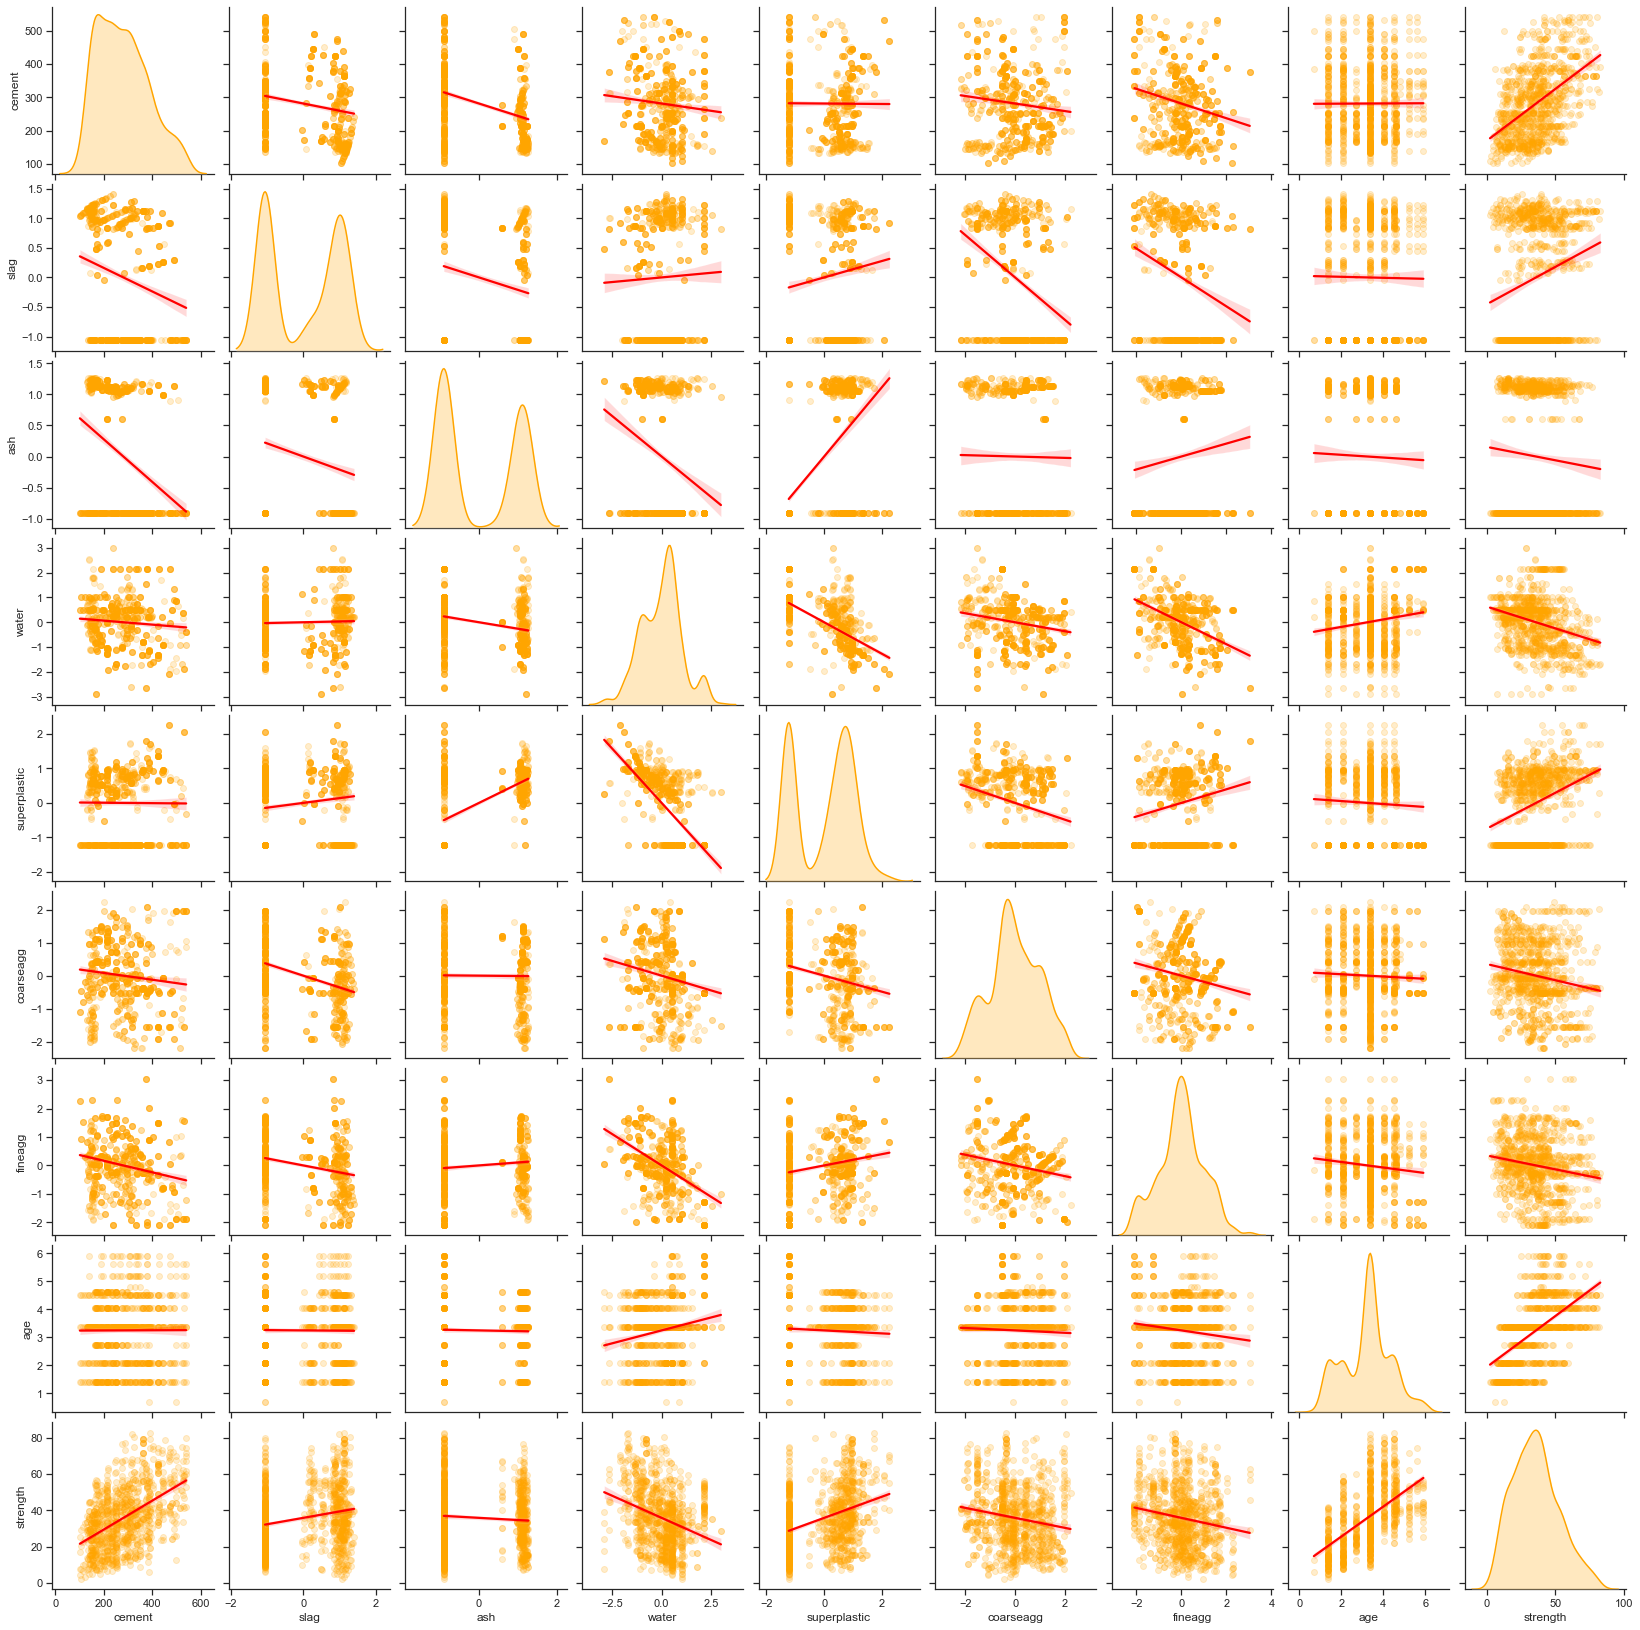

In [24]:
sns.pairplot(concreteDf_aggregated, diag_kind='kde', kind='reg', diag_kws={'color':'orange'},
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.2, 'color':'orange'}})

* Scaling has made the mixup of gaussians more separate and reduced the number of spikes in other variables.
* Age variable is more uniform in terms of predictability as it shows an upward trend.

### $R^2$ & Adjusted $R^2$
Let us check the Adjusted $R^2$ value with all the independent variables.

In [25]:
ols_aggregated = smf.ols(formula= 'strength ~ cement+age+coarseagg+fineagg+slag+superplastic+water+ash', data = concreteDf_aggregated).fit()
print(ols_aggregated.summary())

                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     526.1
Date:                Mon, 09 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:04:45   Log-Likelihood:                -3519.9
No. Observations:                1030   AIC:                             7058.
Df Residuals:                    1021   BIC:                             7102.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -18.1930      1.286    -14.149   

Summary shows the value of Adjusted $R^2$ has increased significantly to **0.803**. It might be appropriate to evaluate the models with these values to get a feel of which would be an ideal model that can give a good score.

### Evaluating Models

In [26]:
concreteDf_X = concreteDf_aggregated.loc[:, concreteDf_aggregated.columns != 'strength']
concreteDf_y = concreteDf_aggregated['strength']
evaluate_models(concreteDf_X, concreteDf_y)

Model      Mean       Std  \
8                      Linear with Power  0.796253  0.033114   
11            Linear with Robust + Power  0.795078  0.033753   
10  Linear with Min-Max + Robust + Power  0.795078  0.033753   
9            Linear with Min-Max + Power  0.793634  0.034497   
1                                  Lasso  0.793605  0.036160   
2                                  Ridge  0.793534  0.036164   
0                                 Linear  0.793534  0.036164   
7                    Linear with Min-Max  0.793534  0.036164   
6                     Ridge with Min-Max  0.793354  0.035758   
4                     Huber with Min-Max  0.792670  0.034034   
3                                  Huber  0.774735  0.042572   
5                     Lasso with Min-Max  0.529008  0.032632   

   Confidence [ 99.7% ]  
8         74.3% - 85.7%  
11        74.3% - 85.7%  
10        74.3% - 85.7%  
9         74.3% - 85.7%  
1         74.3% - 85.7%  
2         74.3% - 85.7%  
0         74.3% - 85.7%  
7         74.3% - 85.7%  
6         74.3% - 85.7%  
4         74.3% - 85.7%  
3         74.3% - 85.7%  
5         74.3% - 85.7%

**Linear with Power transformation** has resulted in the best evaluation score of **79.62%** with the given data and hence can be chosen as a right combination for the next step

### Univariate plots of independent variables

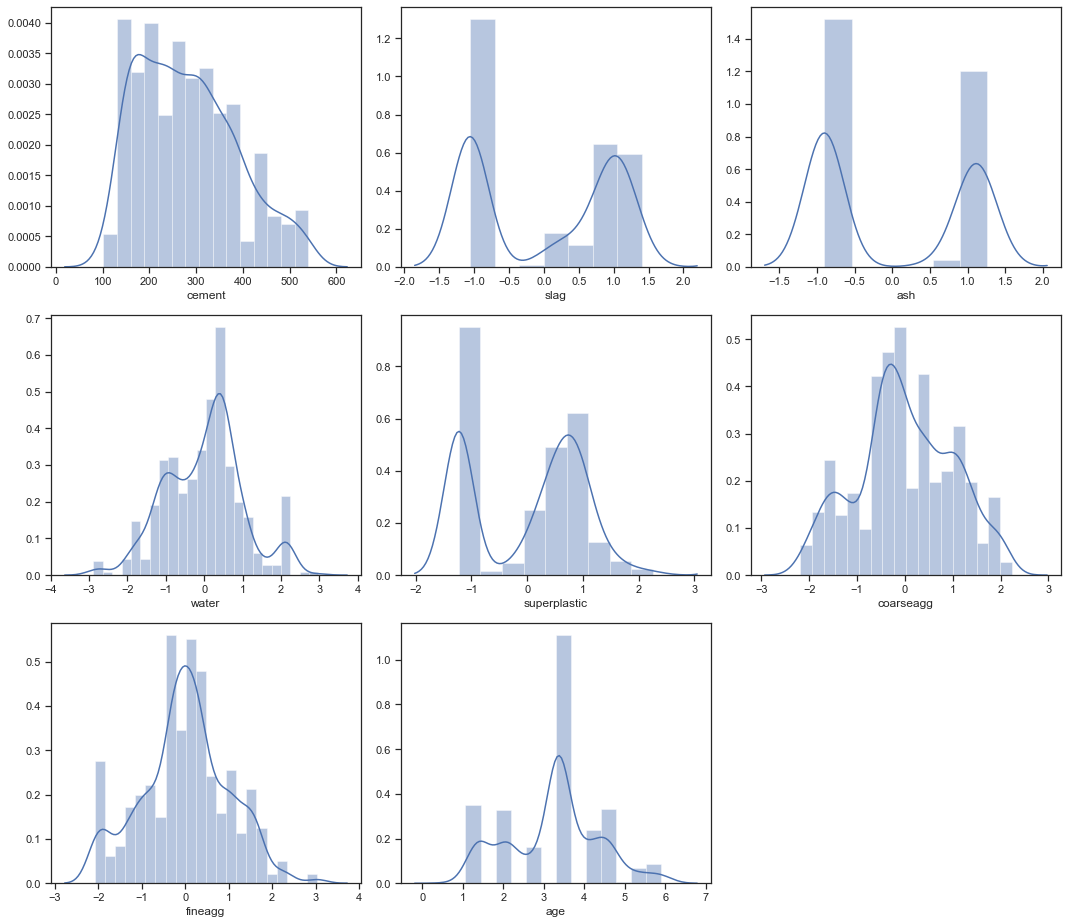

In [27]:
fig = plt.figure(figsize=(15, 13))
for feature, num in zip(concreteDf_X.columns, range(1, len(concreteDf_X.columns) + 1)):
    ax = fig.add_subplot(3, 3, num)
    sns.distplot(concreteDf_X[feature])
plt.tight_layout()
plt.show()

* The plots have less mixup of gaussians in the 'slag', 'ash' and 'superplastic' variables
* 'water' variable is more smoother now.
* 'coarseagg' and 'fineagg' is more refined after scaling and normalization.

### Plots for detecting Outliers

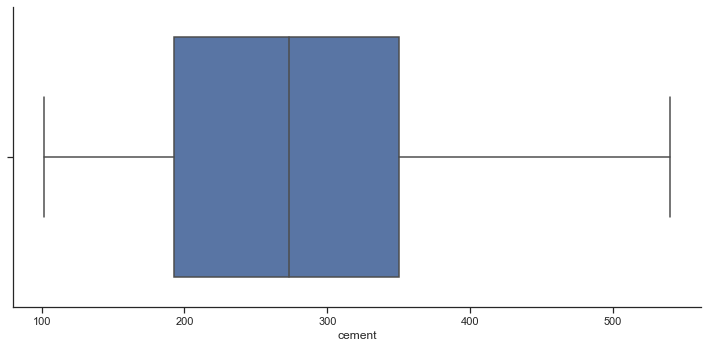

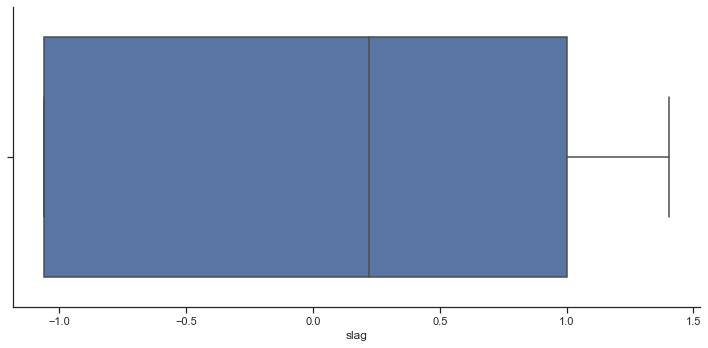

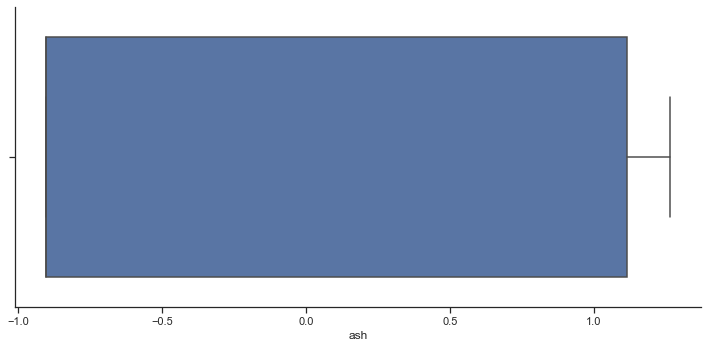

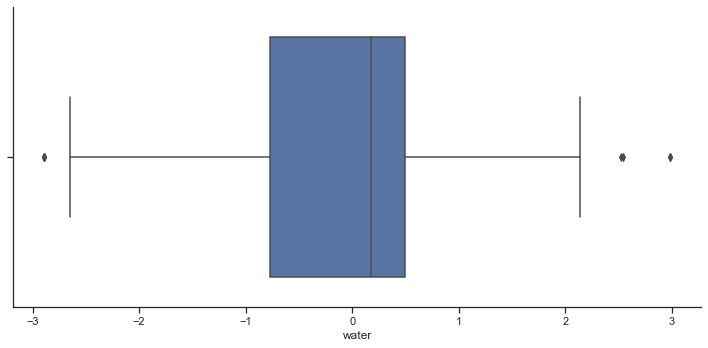

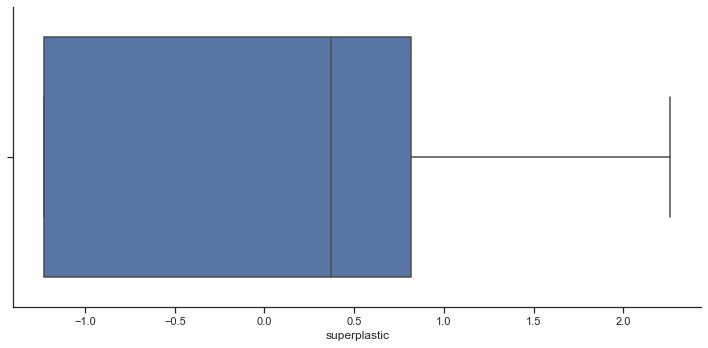

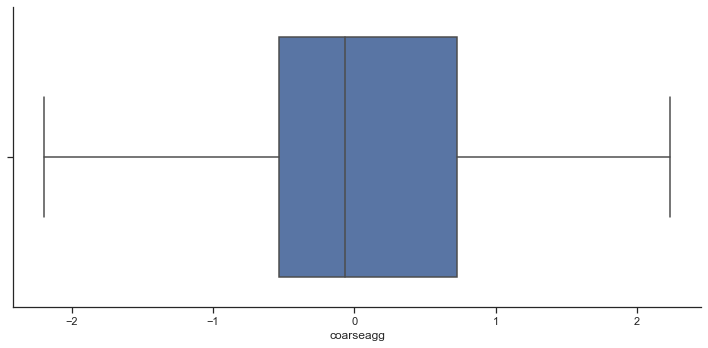

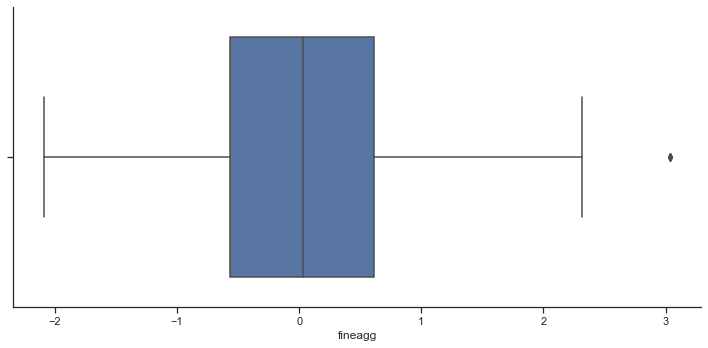

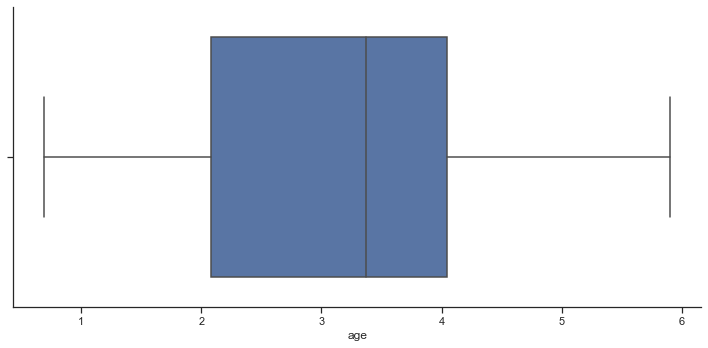

In [28]:
for feature in concreteDf_X.columns:
    sns.catplot(x=feature, kind='box', data=concreteDf_X, aspect=2)

The above plots shows a significant reduction in outliers in the distributions and hence can be used for model building

# Model Building
Let us split the data in to test and train and try to find the score of the best model that can be used. The test data will then be used to score the best model which can be used for further processing

In [29]:
X_train, X_test, y_train, y_test = train_test_split(concreteDf_X, concreteDf_y, test_size=0.3, random_state=1)
score_models(X_train, y_train, X_test, y_test)

Model     Score
8                      Linear with Power  0.822736
11            Linear with Robust + Power  0.821494
10  Linear with Min-Max + Robust + Power  0.821494
9            Linear with Min-Max + Power  0.818963
4                     Huber with Min-Max  0.813447
0                                 Linear  0.811628
7                    Linear with Min-Max  0.811628
2                                  Ridge  0.811627
1                                  Lasso  0.811378
3                                  Huber  0.810950
6                     Ridge with Min-Max  0.808105
5                     Lasso with Min-Max  0.520707

Linear with Power transformation is found to have the best score on this dataset yielding a score of **82.22%**

## Linear or Multinomial
Let us check if a Multinomial regression needs to be applied. Increasing the complexity can yield a more non linear relationship and hence can be evaluated better.

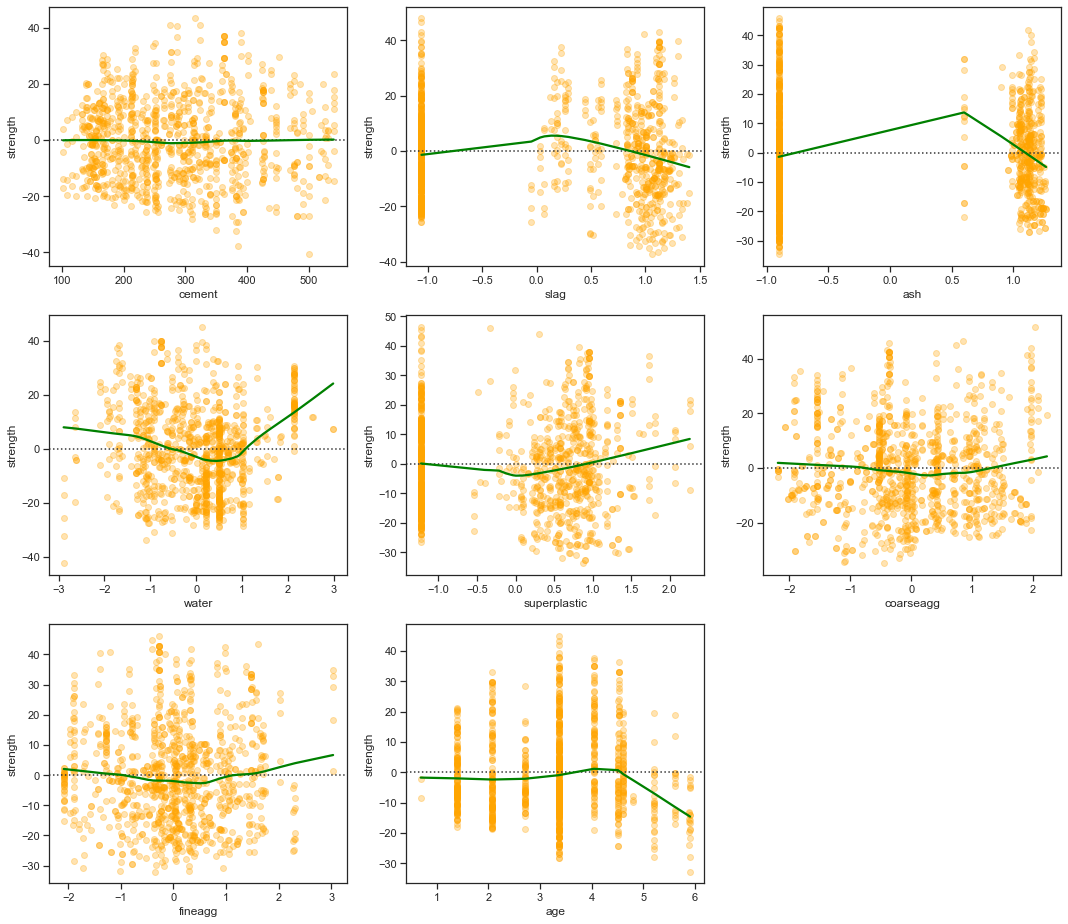

In [30]:
fig = plt.figure(figsize=(15, 13))
for feature, num in zip(concreteDf_X.columns, range(1, len(concreteDf_X.columns) + 1)):
    ax = fig.add_subplot(3, 3, num)
    sns.residplot(x=feature, y='strength', data=concreteDf_aggregated, 
                  scatter_kws={'alpha' : 0.3, 'color' : 'orange'}, 
                  line_kws={'color':'green'}, lowess=True)
plt.tight_layout()
plt.show()

The plots show a non linear relationship between the independent and target variables. Hence it would be beneficial to investigate increasing the complexity in terms of degrees in polynomial features to better evaluate the regression

## Polynomial Features

Text(0.5, 1.0, 'Plot of mean scores vs polynomial degree')

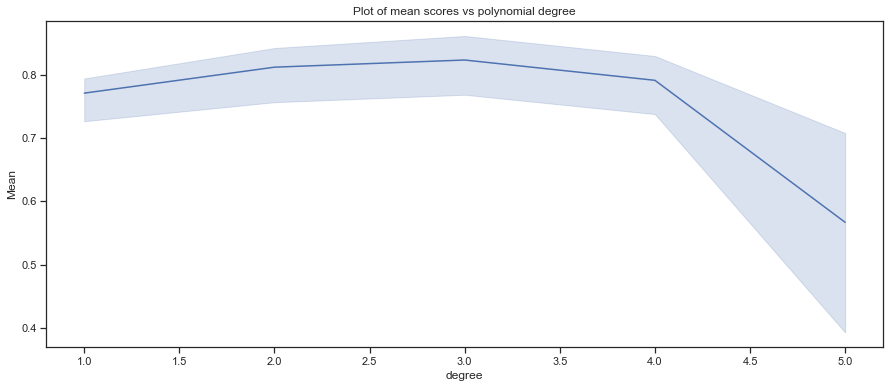

In [31]:
poly_degrees_df = evaluate_poly_features_degrees(concreteDf_X, concreteDf_y, [1, 2, 3, 4, 5])
fig = plt.figure(figsize=(15, 6))
sns.lineplot(x='degree', y='Mean', data=poly_degrees_df)
plt.title('Plot of mean scores vs polynomial degree')

An evaluation of the degrees and plotting above shows that **3** would an ideal number to use as the degree of polynomial features to proceed further. This has yielded the highest mean score out of all other degrees

In [32]:
# Applying 3 as the degree and generating the feature matrix
poly = PolynomialFeatures(degree = 3, interaction_only=True)
X_poly = poly.fit_transform(concreteDf_X)

# Splitting the train and test data for Model building and evaluation
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, concreteDf_y, test_size=0.3, random_state=1)

Using the best evaluated model from *section 4.7* and the polynomial data built from the above degree of 3 we can start model building and evaluation

## Model Scoring & Prediction
Linear with Power transformation yielded the best score. We will use the polynomial features train data with this combination using a pipeline to fit and predict and then output the final score of the resulting model

In [33]:
pipeline = Pipeline(steps=[('t1', PowerTransformer()), ('model', LinearRegression())])
pipeline.fit(X_poly_train, y_poly_train)
print_model_performance(pipeline, X_poly_test, y_poly_test)
y_poly_pred = pipeline.predict(X_poly_test)
y_poly_score = pipeline.score(X_poly_test, y_poly_test)

Accuracy = 86.9513%.


The score of the model has significantly improved to **86.95%**. This indicates that variable taken separately instead of aggregation and using polynomial features with degree 3 has improved the prediction capability of the model.

# Model Tuning
Up until now we have reached **86.95%** performance. It would be possible to use the same polynomial features to squeeze out more performance using **Ensemble Regressors**

## Gradient Boosting Regressor

### Without Cross Validation

In [34]:
params = {'n_estimators': 1000 , 'max_depth': 8, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'lad'}
GB_regr = GradientBoostingRegressor(**params)
GB_regr.fit(X_poly_train, y_poly_train)
print_model_performance(GB_regr, X_poly_test, y_poly_test)
y_GB_score = GB_regr.score(X_poly_test, y_poly_test)

Accuracy = 92.7353%.


### With Cross Validation

In [35]:
GSV_GB_param_grid = {
    'n_estimators':[500, 1000],
    'loss': ['lad', 'huber'],
    'learning_rate': [0.01],
    'max_depth':[5, 8]
}
GB_regr = GradientBoostingRegressor()#**params
# Instantiate the grid search model
grid_search_GB = GridSearchCV(estimator = GB_regr, param_grid = GSV_GB_param_grid, cv = 10, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search_GB.fit(X_poly_train, y_poly_train)
print('Best Parameters are: ')
print(grid_search_GB.best_params_)
best_grid_GB = grid_search_GB.best_estimator_
GSV_GB_predictions = best_grid_GB.predict(X_poly_test)
print_model_performance(best_grid_GB, X_poly_test, y_poly_test)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 12.4min finished


Best Parameters are: 
{'learning_rate': 0.01, 'loss': 'huber', 'max_depth': 5, 'n_estimators': 1000}
Accuracy = 91.4440%.


## AdaBoost Regressor

In [36]:
AB_regr = AdaBoostRegressor(base_estimator=pipeline, n_estimators=500, random_state=1)
AB_regr.fit(X_poly_train, y_poly_train)
print_model_performance(AB_regr, X_poly_test, y_poly_test)
y_AB_score = AB_regr.score(X_poly_test, y_poly_test)

Accuracy = 89.8190%.


## Bagging Regressor

In [37]:
BG_regr = BaggingRegressor(base_estimator=pipeline, n_estimators=50, max_samples=0.7, random_state=1)
BG_regr.fit(X_poly_train, y_poly_train)
print_model_performance(BG_regr, X_poly_test, y_poly_test)
y_BG_score = BG_regr.score(X_poly_test, y_poly_test)

Accuracy = 87.4731%.


## ExtraTrees Regressor

In [38]:
ET_regr = ExtraTreesRegressor(n_estimators=500, random_state=1)
ET_regr.fit(X_poly_train, y_poly_train)
print_model_performance(ET_regr, X_poly_test, y_poly_test)
y_ET_score = ET_regr.score(X_poly_test, y_poly_test)

Accuracy = 92.3456%.


## RandomForest Regressor

In [39]:
params = {'min_samples_split': 2, 'oob_score': True}
RF_regr = RandomForestRegressor(**params, random_state=1)
RF_regr.fit(X_poly_train, y_poly_train)
print_model_performance(RF_regr, X_poly_test, y_poly_test)
y_RF_score = RF_regr.score(X_poly_test, y_poly_test)

Accuracy = 91.5125%.


## DecisionTree Regressor

In [40]:
DT_regr = DecisionTreeRegressor(criterion='friedman_mse', max_depth=10, min_samples_split=2, random_state=1)
DT_regr.fit(X_poly_train, y_poly_train)
print_model_performance(DT_regr, X_poly_test, y_poly_test)
y_DT_score = DT_regr.score(X_poly_test, y_poly_test)

Accuracy = 86.7913%.


## Voting Regressor

In [41]:
estimator_models = [
    ('Gradient Boost', GB_regr), 
    ('AdaBoost', AB_regr), 
    ('Bagging', BG_regr), 
    ('ExtraTrees', ET_regr), 
    ('RandomForest', RF_regr), 
    ('DecisionTree', DT_regr)
]

In [42]:
V_regr = VotingRegressor(estimators=estimator_models)
V_regr.fit(X_poly_train, y_poly_train)
print_model_performance(V_regr, X_poly_test, y_poly_test)
y_V_score = V_regr.score(X_poly_test, y_poly_test)

Accuracy = 93.0605%.


## Stacking Regressor

In [43]:
S_regr = StackingRegressor(estimators=estimator_models, n_jobs=-1)
S_regr.fit(X_poly_train, y_poly_train)
print_model_performance(S_regr, X_poly_test, y_poly_test)
y_S_regr_pred = S_regr.predict(X_poly_test)
y_S_score = S_regr.score(X_poly_test, y_poly_test)

Accuracy = 93.3591%.


# Result
## Model Scores
All the models built so far is plotted to understand how the improvement has taken place and which model has given the best scores. The score is well within **85% to 95%** range as can be seen from the plot.

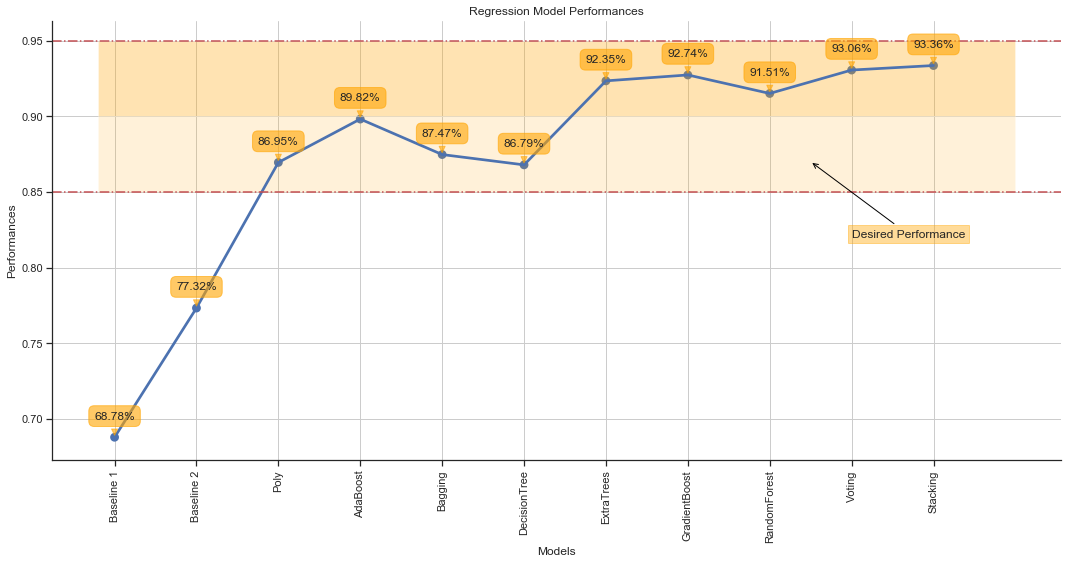

In [46]:
model_names = ['Baseline 1', 'Baseline 2', 'Poly', 'AdaBoost', 'Bagging', 'DecisionTree',
                'ExtraTrees', 'GradientBoost', 'RandomForest', 'Voting', 'Stacking']
performances = [y_baseline_score, y_baseline_1_score, y_poly_score,
                                       y_AB_score, y_BG_score, y_DT_score, y_ET_score, y_GB_score,
                                       y_RF_score, y_V_score, y_S_score]
data = pd.DataFrame({'Models' : model_names, 'Performances': performances})
values = data['Performances']
plt.figure(figsize=(15, 8))
ax = sns.pointplot(x='Models', y='Performances', data=data)
for i, value in zip(range(0, len(values)), values):
    plt.annotate('%.2f%%' % (value*100), xy=(i, value), xytext=(i, value + 0.012), ha = 'center',
             bbox={'boxstyle': 'round', 'pad': 0.45, 'facecolor':  'orange', 'edgecolor': 'orange', 'alpha': 0.6},
             arrowprops={'arrowstyle':'wedge, tail_width=0.5', 'alpha':0.6, 'color': 'orange'})
plt.title('Regression Model Performances')
plt.xticks(rotation=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True)
ax.axhline(y=0.85, linewidth=1.5, color='r', linestyle='dashdot')
ax.axhline(y=0.95, linewidth=1.5, color='r', linestyle='dashdot')
ax.fill_between(x=(-0.2, len(values)), y1=0.85, y2=0.90, facecolor='orange', alpha=0.15)
ax.fill_between(x=(-0.2, len(values)), y1=0.90, y2=0.95, facecolor='orange', alpha=0.3)
ax.annotate('Desired Performance', xy=(8.5, 0.87), xytext=(9, 0.82),
                   arrowprops={'arrowstyle':'->', 'color': 'black'}, 
                   bbox={'pad': 4, 'facecolor':'orange', 'alpha': 0.4, 'edgecolor':'orange'});
plt.tight_layout()
plt.show()

## Actual vs Predictions

A plot between the actual and predicted values is shown below from different models starting from the baseline to indicate how the variation between them has significantly reduced

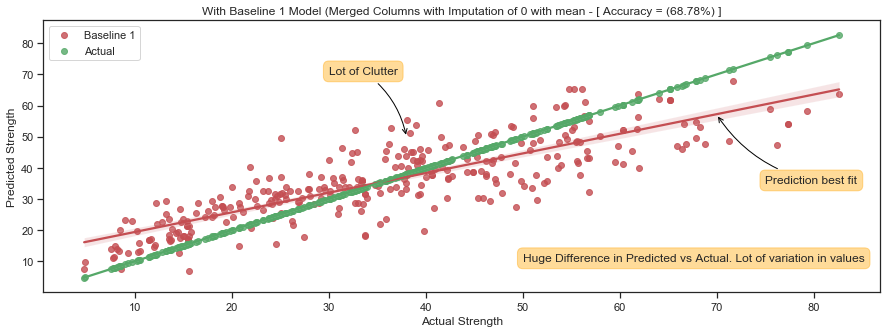

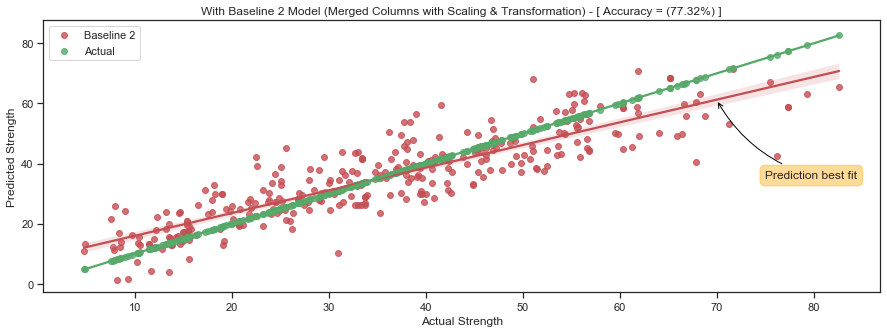

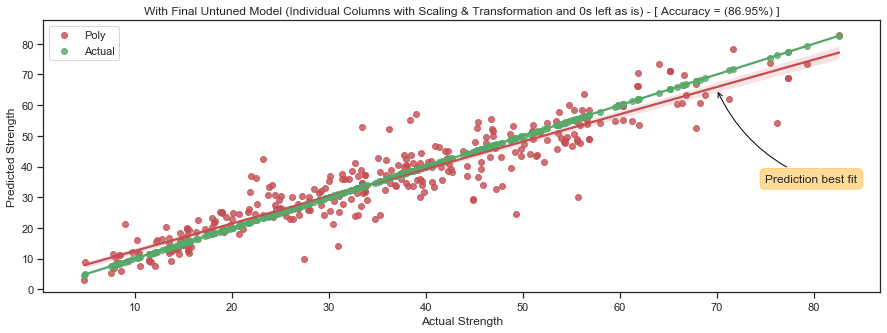

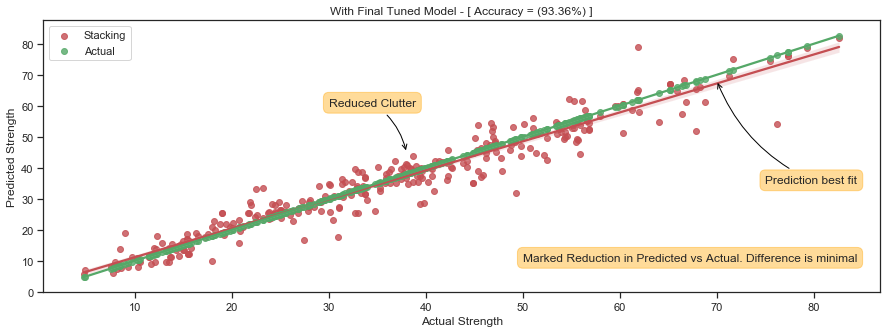

In [45]:
plt.figure(figsize=(15, 5))
sns.regplot(x=y_baseline_test, y=y_baseline_pred, color='r', label='Baseline 1')
sns.regplot(x=y_baseline_test, y=y_baseline_test, color='g', label='Actual')
plt.title('With Baseline 1 Model (Merged Columns with Imputation of 0 with mean - [ Accuracy = (%.2f%%) ]' % (y_baseline_score * 100))
plt.xlabel('Actual Strength')
plt.ylabel('Predicted Strength')
plt.annotate('Lot of Clutter', xy=(38, 50), xytext=(30, 70),
             arrowprops={'arrowstyle': '->', 'color': 'black', 'connectionstyle':'arc3,rad=-0.2'},
             bbox={'boxstyle': 'round', 'pad': 0.45, 'edgecolor': 'orange', 'facecolor': 'orange', 'alpha': 0.4});
plt.annotate('Prediction best fit', xy=(70, 57), xytext=(75, 35),
             arrowprops={'arrowstyle': '->', 'color': 'black', 'connectionstyle':'arc3,rad=-0.2'},
             bbox={'boxstyle': 'round', 'pad': 0.45, 'edgecolor': 'orange', 'facecolor': 'orange', 'alpha': 0.4});
plt.annotate('Huge Difference in Predicted vs Actual. Lot of variation in values', xy=(50, 10), xytext=(50, 10),
             bbox={'boxstyle': 'round', 'pad': 0.45, 'edgecolor': 'orange', 'facecolor': 'orange', 'alpha': 0.4});
plt.legend()
plt.show()
plt.figure(figsize=(15, 5))
sns.regplot(x=y_baseline_1_test, y=y_baseline_1_pred, color='r', label='Baseline 2')
sns.regplot(x=y_baseline_1_test, y=y_baseline_1_test, color='g', label='Actual')
plt.title('With Baseline 2 Model (Merged Columns with Scaling & Transformation) - [ Accuracy = (%.2f%%) ]' % (y_baseline_1_score * 100))
plt.xlabel('Actual Strength')
plt.ylabel('Predicted Strength')
plt.annotate('Prediction best fit', xy=(70, 61), xytext=(75, 35),
             arrowprops={'arrowstyle': '->', 'color': 'black', 'connectionstyle':'arc3,rad=-0.2'},
             bbox={'boxstyle': 'round', 'pad': 0.45, 'edgecolor': 'orange', 'facecolor': 'orange', 'alpha': 0.4});
plt.legend()
plt.show()
plt.figure(figsize=(15, 5))
sns.regplot(x=y_poly_test, y=y_poly_pred, color='r', label='Poly')
sns.regplot(x=y_poly_test, y=y_poly_test, color='g', label='Actual')
plt.title('With Final Untuned Model (Individual Columns with Scaling & Transformation and 0s left as is) - [ Accuracy = (%.2f%%) ]' % (y_poly_score * 100))
plt.xlabel('Actual Strength')
plt.ylabel('Predicted Strength')
plt.annotate('Prediction best fit', xy=(70, 65), xytext=(75, 35),
             arrowprops={'arrowstyle': '->', 'color': 'black', 'connectionstyle':'arc3,rad=-0.2'},
             bbox={'boxstyle': 'round', 'pad': 0.45, 'edgecolor': 'orange', 'facecolor': 'orange', 'alpha': 0.4});
plt.legend()
plt.show()
plt.figure(figsize=(15, 5))
sns.regplot(x=y_poly_test, y=y_S_regr_pred, color='r', label='Stacking')
sns.regplot(x=y_poly_test, y=y_poly_test, color='g', label='Actual')
plt.title('With Final Tuned Model - [ Accuracy = (%.2f%%) ]' % (y_S_score * 100))
plt.xlabel('Actual Strength')
plt.ylabel('Predicted Strength')
plt.annotate('Reduced Clutter', xy=(38, 45), xytext=(30, 60),
             arrowprops={'arrowstyle': '->', 'color': 'black', 'connectionstyle':'arc3,rad=-0.2'},
             bbox={'boxstyle': 'round', 'pad': 0.45, 'edgecolor': 'orange', 'facecolor': 'orange', 'alpha': 0.4});
plt.annotate('Prediction best fit', xy=(70, 68), xytext=(75, 35),
             arrowprops={'arrowstyle': '->', 'color': 'black', 'connectionstyle':'arc3,rad=-0.2'},
             bbox={'boxstyle': 'round', 'pad': 0.45, 'edgecolor': 'orange', 'facecolor': 'orange', 'alpha': 0.4});
plt.annotate('Marked Reduction in Predicted vs Actual. Difference is minimal', xy=(50, 10), xytext=(50, 10),
             bbox={'boxstyle': 'round', 'pad': 0.45, 'edgecolor': 'orange', 'facecolor': 'orange', 'alpha': 0.4});
plt.legend()
plt.show()